# AlexNet CIFAR-10

# Resources
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://blog.paperspace.com/alexnet-pytorch/
- https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py
- https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
- https://en.wikipedia.org/wiki/AlexNet
- http://d2l.ai/chapter_convolutional-modern/alexnet.html
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

# Imports

In [1]:
# import pandas as pd # dataframes
# import torchvision.transforms as transforms

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchmetrics
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard.writer import SummaryWriter # http://localhost:6006/ # tensorboard --logdir=runs # https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

# Device Configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} processing")

#torch.set_default_dtype(torch.float16)

Using cuda processing


# Hyperparameters, Loss Function & Metrics

In [3]:
neural_net = "AlexNet"
dataset = "CIFAR-10"
run_directory = f"runs/{neural_net}-{dataset}"

classes = 10
batch_size = 32

epoch_tuning_limit = 3 # number of epochs to go for when tuning the hyperparameters
epoch_training_limit = 20 # number of epochs to go for when full training

learning_rates_tuning = [0.01, 0.005, 0.001,  0.0005, 0.0001] # learning rates to tune
#learning_rates_adam = [] # to be determined by tuning
#learning_rates_sgd = [] # to be determined by tuning

loss_function = nn.CrossEntropyLoss() # Loss function to use

metric_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=classes, average='macro').to(device) # https://www.evidentlyai.com/classification-metrics/multi-class-metrics#:~:text=Macro%2Daveraging%20shows%20average%20performance,and%20accuracy%20are%20the%20same.
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = classes, average='macro').to(device) # https://stackoverflow.com/questions/37358496/is-f1-micro-the-same-as-accuracy

# Load Datasets

In [4]:
dir = './data'
download = True
transform = transforms.Compose( # define normalization transform
    [
      transforms.Resize((224,224)), # resize images to 224x224
      transforms.ToTensor(), # transform image to tensor and torch format
      transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)) # apply normalize across all the channels for the image
      # mention why 0.5
    ]
)

# Get Datasets
dataset_train = datasets.CIFAR10(root = dir, download=download, transform=transform, train = True)
dataset_test = datasets.CIFAR10(root = dir, download=download, transform=transform, train = False)

# Split the training dataset into a training set (90% samples) and a validation set (10% samples).
size_train = int(0.9 * len(dataset_train))
size_valid = len(dataset_train) - size_train

dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train, [size_train, size_valid])

#from torch.utils.data import Subset # massively shortening training times to allow for testing of graphs
#dataset_train = Subset(dataset_train, range(1000))
#dataset_valid = Subset(dataset_valid, range(1000))
#dataset_test = Subset(dataset_test, range(1000))


# Data loaders split the data up into batches as determined by the batch size
loader_train = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
loader_valid = torch.utils.data.DataLoader(dataset = dataset_valid, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True)
loader_test = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True)

# Verify the sizes of the training and validation sets
print(f"Training Size: {len(dataset_train)}")
print(f"Validation Size: {len(dataset_valid)}")
print(f"Testing Size: {len(dataset_test)}")

Files already downloaded and verified
Files already downloaded and verified
Training Size: 45000
Validation Size: 5000
Testing Size: 10000


# Explore and Visualize Data
- We do basic data analysis on the dataset.
- As we are working with the CIFAR dataset, we can see that each image is an RBG image, with a single object as the focus.
- This object maps to one of the classes the CIFAR dataset

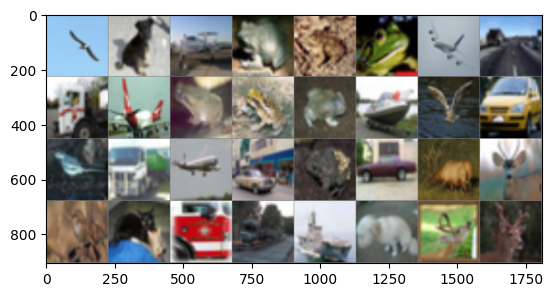

tensor([2, 5, 0, 6, 6, 6, 0, 9, 9, 0, 6, 6, 6, 8, 2, 1, 2, 9, 0, 1, 6, 1, 4, 4,
        2, 3, 9, 9, 8, 5, 4, 4])


In [5]:
def DisplayImage(image): # Normalize and display the image
    image = image / 2 + 0.5 # unnormalize
    npImage = image.numpy() # Convert the image tensor to a NumPy array
    plt.imshow(np.transpose(npImage, (1, 2, 0)))
    plt.show() # display

dateIterator = iter(loader_train)
images, labels = next(dateIterator)

DisplayImage(torchvision.utils.make_grid(images))
print(labels) # to do

# mean color distribtion, distribution of classes 
# https://medium.com/@sehjadkhoja0/title-exploring-and-analyzing-image-data-with-python-79a7f72f4d2b

# Model Architecture
- We use the preset AlexNet model provided by PyTorch.

In [6]:
model = models.AlexNet(num_classes=classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Define Training Function

## Model Wrapper
- We define a wrapper for our model that will help in storing, organzing, and persisting both the model and various metrics

In [7]:
class ModelWrapper:
    def __init__(self, optimizer, batch_size, num_epochs, learning_rate):
        self.log_dir = f'{run_directory}/{optimizer}-{batch_size}BS-{num_epochs}E-{learning_rate}LR'
        self.writer = SummaryWriter(log_dir=self.log_dir)

        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = num_epochs
        self.learning_rate = learning_rate

        self.losses_training_step = [] # loss for a step during model training
        self.losses_training_epoch = [] # loss on the training dataset after an epoch
        self.losses_valid_epoch = [] # loss on the validation dataset after an epoch
        self.loss_test = 0 # loss on the test dataset after a full training loop
        
        self.accuracy_training = [] # accuracy on the training dataset after an epoch
        self.accuracy_valid = [] # accuracy on the validation dataset after an epoch
        self.accuracy_test = 0 # accuracy on the test dataset after a full training loop
        
        self.f1_training = [] # f1 score on the training dataset after an epoch
        self.f1_valid = [] # f1 score on the validation dataset after an epoch
        self.f1_test = 0 # f1 score on the test dataset after a full training loop

        self.start_time = time.time()
        self.end_time = time.time()
    
    def AddModel(self, model):
        self.model = model
    
    def RunTime(self):
        return self.end_time - self.start_time

    def PrintEpochs(self):
        print(f'Trained model with learning rate {self.learning_rate}, for {self.epochs} epochs, using the {self.optimizer} optimizer. {self.RunTime():.2f} seconds.')
        for epoch in range(self.epochs):
            print(f'Epoch {epoch+1}; Valid Loss {self.losses_training_epoch[epoch]:.4f}; '
                  + f'Valid Loss: {self.losses_valid_epoch[epoch]:.4f}; '
                  + f'Valid Accuracy: {(100 * self.accuracy_valid[epoch]):.4f}%; ' 
                  + f'Valid F1: {(100 * self.f1_valid[epoch]):.4f}%')
    
    def PrintFinal(self):
        print(f'Trained model with learning rate {self.learning_rate}, for {self.epochs} epochs, using the {self.optimizer} optimizer. {self.RunTime():.2f} seconds.')
        print(f'Final Train Loss:       {(self.losses_training_epoch[-1]):.4f};     ', end = '')
        print(f'Final Valid Loss:       {(self.losses_valid_epoch[-1]):.4f}')
        print(f'Final Train Accuracy:   {(100 * self.accuracy_training[-1]):.4f}%;      ', end = '')
        print(f'Final Valid Accuracy:   {(100 * self.accuracy_valid[-1]):.4f}%')
        print(f'Final Train F1:         {(100 * self.f1_training[-1]):.4f}%;        ', end = '')
        print(f'Final Valid F1:         {(100 * self.f1_valid[-1]):.4f}%')


In [8]:
def TrainModel(optimizer_choice, batch_size, learning_rate, num_epochs, printStep = False, pretrained = False):
  torch.cuda.empty_cache()
  
  # Model
  if pretrained:
    model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
    model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, classes).to(device) # pretrained AlexNet is meant to output 1000
  else:
    model = models.AlexNet(num_classes=classes).to(device)

  # Wrapper
  wrapper = ModelWrapper(optimizer=optimizer_choice, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate)

  # Optimizer Function
  # this will help change the parameters of the model, influenced by the learning rate
  if optimizer_choice == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  elif optimizer_choice == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
  else:
    return

  # For Epoch
  for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(loader_train): # loop through each batch the dataloader has
      inputs = inputs.to(device) # the input images from the training dataset 
      targets = targets.to(device) # the class labels from the training dataset 

      optimizer.zero_grad() # Zero the parameter gradients

      outputs = model(inputs) # feed the model the inputs, and get predictions off the inputs
      loss = loss_function(outputs, targets) # compare the preditions to the actual target values of the inputs
      loss.backward() # compute the gradients
      optimizer.step() # actually update the model parameters based off the gradients computed previously

      wrapper.losses_training_step.append(loss.item()) # update loss training step

      if printStep and (i%(round((len(loader_train)/3), -1)) == 0):
        print(f'LR: {learning_rate}; Opt: {optimizer}; Epoch {epoch+1}/{num_epochs}; Step: {i+1}/{len(loader_train)}; Loss: {loss.item():.4f}')
        print()
    
    model.eval() # set the model to eval mode so it does not train off the whole training/testing sets
    with torch.no_grad(): # disabling gradient calculation, since we're not computing gradients
      '''
      # training dataset metrics
      loss_total = 0.0 # represents summation of the loss at each step for the training dataset
      metric_accuracy.reset()
      metric_f1.reset()
      for inputs, targets in loader_train:
        inputs = inputs.to(device) # input images from the training dataset
        targets = targets.to(device) # the classes/labels/targets of the input images
        outputs = model(inputs) # the classes/labels/targets probabilities of the input images
        predicted = torch.argmax(outputs.data, 1) # the highest class/label of each input image

        loss = loss_function(outputs, targets) # compute the loss of the step
        loss_total += loss.item() # add the step loss to the total loss

        metric_accuracy.update(predicted, targets) # update the accuracy with the current step info
        metric_f1.update(predicted, targets) # update the f1 with the current step info

      loss_average = loss_total / len(loader_train) # calculate the average loss for the training dataset this epoch
      accuracy_val = metric_accuracy.compute().item() # calculate the accuracy for the training dataset this epoch
      f1_val = metric_f1.compute().item() # calculate the f1 score for the training dataset this epoch

      wrapper.losses_training_epoch.append(loss_average) # update train loss epoch
      wrapper.accuracy_training.append(accuracy_val) # update train accuracy epoch
      wrapper.f1_training.append(f1_val) # update train f1 epoch

      wrapper.writer.add_scalar(f"Loss/Training/{num_epochs}E", loss_average, epoch) # update tensorboard
      wrapper.writer.add_scalar(f"Accuracy/Training/{num_epochs}E", accuracy_val, epoch) # update tensorboard
      wrapper.writer.add_scalar(f"F1/Training/{num_epochs}E", f1_val, epoch) # update tensorboard
      '''
      # validation dataset metrics
      loss_total = 0.0 # represents summation of the loss at each step for the validation dataset
      metric_accuracy.reset()
      metric_f1.reset()
      for inputs, targets in loader_valid: 
        inputs = inputs.to(device) # input images from the validation dataset
        targets = targets.to(device) # get the classes of the test input
        outputs = model(inputs) # predict the classification values of the test input
        predicted = torch.argmax(outputs.data, 1) # get the highest classification value

        loss = loss_function(outputs, targets) # compute the loss of the step
        loss_total += loss.item() # add the step loss to the total loss

        metric_accuracy.update(predicted, targets) # update the accuracy with the current step info
        metric_f1.update(predicted, targets) # update the f1 with the current step info

      loss_average = loss_total / len(loader_valid) # calculate the average loss for the validation dataset this epoch
      accuracy_val = metric_accuracy.compute().item() # calculate the accuracy for the validation dataset this epoch
      f1_val = metric_f1.compute().item() # calculate the f1 score for the validation dataset this epoch

      wrapper.losses_valid_epoch.append(loss_average) # update valid loss epoch
      wrapper.accuracy_valid.append(accuracy_val) # update valid accuracy epoch
      wrapper.f1_valid.append(f1_val) # update valid f1 epoch
      
      wrapper.writer.add_scalar(f"Loss/Valid/{num_epochs}E", loss_average, epoch) # update tensorboard
      wrapper.writer.add_scalar(f"Accuracy/Valid/{num_epochs}E", accuracy_val, epoch) # update tensorboard
      wrapper.writer.add_scalar(f"F1/Valid/{num_epochs}E", f1_val, epoch) # update tensorboard

    model.train() # set model back in training mode

  wrapper.writer.flush()
  wrapper.end_time = time.time()
  wrapper.AddModel(model=model)
  return wrapper

# Hyperparameter Tuning
- We train multiple models from the tuning learning rate values both optimizers over a limited number of epochs.
- We will select the two most promising learning rates for each optimizer and run those learning rates to the specified epoch training limit

In [9]:
print(f'Training {len(learning_rates_tuning)} learning rates for both Adam and SGD loss functions over {epoch_tuning_limit} epochs.')
time_tuning_start = time.time()

models_tuning_adam = []
for learning_rate in learning_rates_tuning:
  models_tuning_adam.append(TrainModel(optimizer_choice='Adam', batch_size=batch_size, num_epochs=epoch_tuning_limit, learning_rate=learning_rate))

models_tuning_sgd = []
for learning_rate in learning_rates_tuning:
  models_tuning_sgd.append(TrainModel(optimizer_choice='SGD', batch_size=batch_size, num_epochs=epoch_tuning_limit, learning_rate=learning_rate))

time_tuning_end = time.time()
time_tuning = time_tuning_end - time_tuning_start

print(f"Training finished, elapsed time: {time_tuning:.2f} seconds ({(time_tuning/60):.2f} minutes)")

Training 5 learning rates for both Adam and SGD loss functions over 3 epochs.


KeyboardInterrupt: 

## Selecting Learning Rates for Each Optimizer
- See which learning rates provide the highest validation accuracy after the specified number of tuning epochs.
- Select two learning rates which result in the highest validation accuracy.

In [ ]:
print('Adam Metrics')
for metrics in models_tuning_adam:
    metrics.PrintFinal()
    print()

print('SGD Metrics')
for metrics in models_tuning_sgd:
    metrics.PrintFinal()
    print()

models_sorted = sorted(models_tuning_adam, key=lambda x: x.accuracy_valid[-1], reverse=True)
learning_rates_adam = [wrapper.learning_rate for wrapper in models_sorted[:2]] # learning rates to test for Adam

models_sorted = sorted(models_tuning_sgd, key=lambda x: x.accuracy_valid[-1], reverse=True)
learning_rates_sgd = [wrapper.learning_rate for wrapper in models_sorted[:2]] # learning rates to test for SGD

print('Selected LR Adam')
for lr in learning_rates_adam:
    print(lr)
print()
print('Selected LR SGD')
for lr in learning_rates_sgd:
    print(lr)

# Train Models
- We train the selected learning rates for both optimizers to the number of epochs defined by the epoch_training_limit

In [ ]:
print(f'Training {len(learning_rates_adam) + len(learning_rates_sgd)} models over {epoch_training_limit} epochs.')
time_training_start = time.time()

models_training_adam = []
for learning_rate in learning_rates_adam:
  models_training_adam.append(TrainModel(optimizer_choice='Adam', batch_size=batch_size, num_epochs=epoch_training_limit, learning_rate=learning_rate))

models_training_sgd = []
for learning_rate in learning_rates_sgd:
  models_training_sgd.append(TrainModel(optimizer_choice='SGD', batch_size=batch_size, num_epochs=epoch_training_limit, learning_rate=learning_rate))

time_training_end = time.time()
time_training = time_training_end - time_training_start

print(f"Training finished, elapsed time: {time_training:.2f} seconds ({(time_training/60):.2f} minutes)")

In [ ]:
print('Adam Metrics')
for metrics in models_training_adam:
    metrics.PrintEpochs()
    print()

print('SGD Metrics')
for metrics in models_training_sgd:
    metrics.PrintEpochs()
    print()

# Evaluate Model Accuracy
- We evaluate the accuracy of the model on both the training and validation datasets.
- We compare the accuracy of the selected learning rates within each optimizer.
- We compare the accuracy of the two optimizers against each other

## Define Plot Functions

In [ ]:
# Plots the various metrics for a model for each learning rate on a seperate plot, for a single optimizer
def PlotMetricsByLearningRate(metrics_optimizer, optimizer_name):
    plt.close()
    range_epochs = range(1, epoch_training_limit+1)

    ncols = len(metrics_optimizer)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15,5)) # prepare subplot
    for col in range(ncols):
        wrapper = metrics_optimizer[col]

        axes[col].plot(range_epochs, [value * 100 for value in wrapper.accuracy_training], label=f'Training Accuracy') # training accuracy
        axes[col].plot(range_epochs, [value * 100 for value in wrapper.accuracy_valid], label=f'Validation Accuracy') # validation accuracy
        axes[col].plot(range_epochs, [value * 100 for value in wrapper.f1_training], label=f'Training F1') # training F1
        axes[col].plot(range_epochs, [value * 100 for value in wrapper.f1_valid], label=f'Validation F1') # validation F1

        axes[col].set_title(f'Learning Rate {wrapper.learning_rate}')
        axes[col].legend()

        axes[col].set_xlabel(f'Epoch')
        axes[col].set_xticks(range_epochs)
        axes[col].set_xlim(1, epoch_training_limit)
        
        axes[col].set_ylabel(f'Value (%)')
        axes[col].set_ylim(0,100)

    plt.suptitle(f'Model Metrics by Learning Rates using the {optimizer_name} optimizer')
    plt.show()

In [ ]:
def PlotAccuracy(metrics):
    plt.close()
    range_epochs = range(1, epoch_training_limit+1)
    
    for wrapper in metrics:
        plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_training], label=f'{wrapper.optimizer}/{wrapper.learning_rate}/Training') # training accuracy
        plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_valid], label=f'{wrapper.optimizer}/{wrapper.learning_rate}/Validation') # validation accuracy

    plt.suptitle(f'{neural_net}-{dataset}') # Super Title
    plt.title(f'Optimal Models') # Title
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)
    plt.grid(True)

    plt.xlabel('Epochs')
    plt.xlim(1, epoch_training_limit)
    plt.xticks(range_epochs)

    plt.ylabel('Accuracy (%)')

    plt.show()

## Adam Optimizer Metrics

In [ ]:
PlotMetricsByLearningRate(models_training_adam, 'Adam')

## SGD Optimizer Metrics

In [ ]:
PlotMetricsByLearningRate(models_training_adam, 'SGD')

## Adam vs SGD Accuracy

In [ ]:
PlotAccuracy((models_training_adam + models_training_sgd))

# Predictions on Test Set
- We get the loss, the accuracy, and the F1 score of the model against the test set.
- These are not definitive metrics, as the test set is only evaluated after fully training the model as defined by epoch_test_limit.
- This means that the model could have overfitted by the number of epochs specified.

In [ ]:
def PredictTestSet(wrapper):
    model.eval()
    model.to(device)
    with torch.no_grad():
        loss_total = 0.0
        metric_accuracy.reset()
        metric_f1.reset()

        for inputs, targets in loader_test:
            inputs = inputs
            targets = targets
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)

            loss = loss_function(outputs, targets)
            loss_total += loss.item()

            metric_accuracy.update(predicted, targets)
            metric_f1.update(predicted, targets)

        wrapper.loss_test = loss_total / len(loader_test)
        wrapper.accuracy_test = metric_accuracy.compute().item()
        wrapper.f1_test = metric_f1.compute().item()

In [ ]:
for wrapper in (models_training_adam + models_training_sgd):
    PredictTestSet(wrapper)

for wrapper in (models_training_adam + models_training_sgd):
    print(f'Opt: {wrapper.optimizer}; LR: {wrapper.learning_rate}')
    print(wrapper.loss_test)
    print(wrapper.accuracy_test)
    print(wrapper.f1_test)
    print()

# Export Graphs for Report
- Loss/Epoch
- Accuracy/Epoch
- F1/Epoch
- Loss/Step
    

In [ ]:
# Training vs Validation Loss/Epoch
for wrapper in (models_training_adam + models_training_sgd):
    plt.close()
    
    # Data
    range_epochs = range(1, wrapper.epochs+1)
    plt.plot(range_epochs, wrapper.losses_training_epoch, label='Training Loss', color='blue')
    plt.plot(range_epochs, wrapper.losses_valid_epoch, label='Validation Loss', color='red')

    plt.xlabel('Epochs')
    plt.xlim(1, wrapper.epochs)
    plt.xticks([1, 5, 10, 15, 20])

    plt.ylabel('Loss')
    
    plt.suptitle(f'{neural_net}-{dataset}') # Super Title
    plt.title(f'{wrapper.optimizer} Optimizer with learning rate {wrapper.learning_rate}') # Title
    plt.legend()

    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-loss-epoch.png')

# Accuracy/Epoch
for wrapper in (models_training_adam + models_training_sgd):
    plt.close()
    range_epochs = range(1, wrapper.epochs+1)
    y_data = [value * 100 for value in wrapper.accuracy_valid]

    plt.plot(range_epochs, y_data, label='Validation Accuracy', color='blue')

    plt.title(f'{wrapper.optimizer} Optimizer with learning rate {wrapper.learning_rate}')
    plt.suptitle(f'{neural_net}-{dataset}')

    plt.xlabel('Epochs')
    plt.xlim(1, wrapper.epochs)
    plt.xticks([1, 5, 10, 15, 20])

    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)

    plt.legend()

    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-acc-valid-epoch.png')

# F1 Score/Epoch
for wrapper in (models_training_adam + models_training_sgd):
    plt.close()
    range_epochs = range(1, wrapper.epochs+1)
    y_data = [value * 100 for value in wrapper.f1_valid]

    plt.plot(range_epochs, y_data, label='Validation F1 Score', color='blue')

    plt.title(f'{wrapper.optimizer} Optimizer with learning rate {wrapper.learning_rate}')
    plt.suptitle(f'{neural_net}-{dataset}')

    plt.xlabel('Epochs')
    plt.xlim(1, wrapper.epochs)
    plt.xticks([1, 5, 10, 15, 20])

    plt.ylabel('F1 Score (%)')
    plt.ylim(0, 100)

    plt.legend()

    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-f1-valid-epoch.png')

In [ ]:
# Training Loss/Step
for wrapper in (models_training_adam + models_training_sgd):
    plt.close()
    
    # Data
    range_epochs = range(1, len(wrapper.losses_training_step)+1)
    plt.plot(range_epochs, wrapper.losses_training_step, label='Training Loss/Steps', color='blue')

    plt.xlabel('Steps')
    plt.xlim(1, len(wrapper.losses_training_step))

    plt.ylabel('Loss')
    
    plt.suptitle(f'{neural_net}-{dataset}') # Super Title
    plt.title(f'{wrapper.optimizer} Optimizer with learning rate {wrapper.learning_rate}') # Title
    plt.legend()

    #plt.show()
    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-loss-step.png')